In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

merton portfoolio for the q learning

# IMPLEMENT THIS FOR THE REAL_DATA

# using the equation


# merton portfolio using the analytic solution

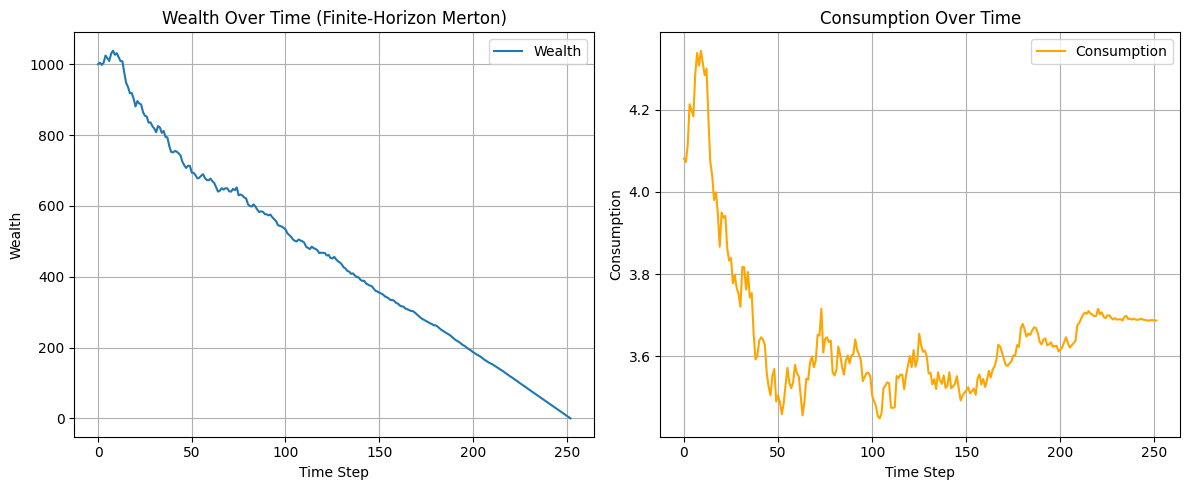


Final Wealth: -0.00
Terminal Utility: -13.2738


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Market Environment ---
class Market:
    def __init__(self, mu, sigma, r, T, dt, s0):
        self.mu = mu
        self.sigma = sigma
        self.r = r
        self.T = T
        self.dt = dt
        self.steps = int(T / dt)
        self.s0 = s0
        self.prices = self.simulate_prices()

    def simulate_prices(self):
        np.random.seed(42)
        prices = [self.s0]
        for i in range(self.steps):
            s = prices[-1]
            dw = np.random.normal(0, np.sqrt(self.dt))
            s_new = s * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.dt + self.sigma * dw)
            prices.append(s_new)
        return prices

# --- Merton Strategy ---
class MertonStrategy:
    def __init__(self, mu, sigma, r, gamma):
        self.mu = mu
        self.sigma = sigma
        self.r = r
        self.gamma = gamma

    def optimal_allocation(self):
        return (self.mu - self.r) / (self.gamma * self.sigma ** 2)

# --- Finite-Horizon Merton Portfolio ---
class MertonPortfolio:
    def __init__(self, initial_wealth, strategy: MertonStrategy, market: Market, rho=0.04):
        self.initial_wealth = initial_wealth
        self.strategy = strategy
        self.market = market
        self.steps = market.steps
        self.dt = market.dt
        self.history = [initial_wealth]
        self.consumption_history = []
        self.returns = []
        self.rho = rho
        self.T = market.T

    def optimal_consumption_fraction(self, t):
        """Finite-horizon optimal consumption for log utility."""
        return self.rho / (1 - np.exp(-self.rho * (self.T - t)))

    def time_dependent_allocation(self, t):
        """Reduce risky exposure as time progresses."""
        pi_star = self.strategy.optimal_allocation()
        return pi_star * (1 - t / self.T)

    def run(self):
        wealth = self.initial_wealth

        for t in range(self.steps):
            time = t * self.dt
            price_now = self.market.prices[t]
            price_next = self.market.prices[t + 1]

            # Allocation and returns
            pi = self.time_dependent_allocation(time)
            risky = pi * wealth
            riskless = (1 - pi) * wealth

            risky_return = (price_next - price_now) / price_now
            riskless_return = (1 + self.market.r) ** self.dt - 1

            new_wealth = risky * (1 + risky_return) + riskless * (1 + riskless_return)

            # Consumption
            consumption_frac = self.optimal_consumption_fraction(time)
            consumption = consumption_frac * new_wealth * self.dt
            new_wealth -= consumption

            # Store results
            self.returns.append((new_wealth - wealth) / wealth)
            self.consumption_history.append(consumption)
            wealth = new_wealth
            self.history.append(wealth)

        self.final_wealth = wealth
        self.terminal_utility = np.log(max(wealth, 1e-6)) * np.exp(-self.rho * self.T)

    def plot_results(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history, label="Wealth")
        plt.xlabel("Time Step")
        plt.ylabel("Wealth")
        plt.title("Wealth Over Time (Finite-Horizon Merton)")
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.consumption_history, label="Consumption", color='orange')
        plt.xlabel("Time Step")
        plt.ylabel("Consumption")
        plt.title("Consumption Over Time")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# --- Main ---
def run_merton_finite_horizon():
    mu, sigma, r, T, dt, s0 = 0.08, 0.2, 0.03, 1, 1 / 252, 100
    initial_wealth = 1000
    gamma = 1  # Log utility
    rho = 0.04

    market = Market(mu, sigma, r, T, dt, s0)
    strategy = MertonStrategy(mu, sigma, r, gamma)
    portfolio = MertonPortfolio(initial_wealth, strategy, market, rho)
    portfolio.run()
    portfolio.plot_results()

    print(f"\nFinal Wealth: {portfolio.final_wealth:.2f}")
    print(f"Terminal Utility: {portfolio.terminal_utility:.4f}")

if __name__ == "__main__":
    run_merton_finite_horizon()


Here, note that the main goal of the Merton portfolio strategy is to consume more and not allocate any wealth in the future (i.e., after time
𝑡
=
𝑇
t=T). That is why the optimal policy encourages gradually depleting wealth as
𝑡
→
𝑇
t→T, leading to a decreasing wealth trajectory — since holding wealth beyond the horizon provides no utility in the finite-horizon framework.

# data

In [ ]:
import yfinance as yf

# Nifty 50 symbol on Yahoo Finance is ^NSEI
nifty = yf.download("^NSEI", start="2020-01-01", end="2025-01-01")



/tmp/ipython-input-6-4105810277.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# In the Merton model,μ is treated as known and constant.here we will find the μ using the historical data
# st is log normaly distributed
nifty["log_return"]=np.log(nifty["Close"]/nifty["Close"].shift(1))
mu_nifty=nifty["log_return"].mean()
sigma_nifty=nifty["log_return"].std()

In [ ]:
# here we are taking the T as in years so we want to use the miu_nifty and sigma_nifty as in annulaized form
annu_mu_nifty=mu_nifty*252
annu_sigma_nifty = np.sqrt(sigma_nifty)*np.sqrt(252)
# r is 6.60 for the sbi bank fixed deposit for the general public


In [ ]:
nifty['Close'].iloc[-1].item()


23644.80078125

# implementation for the analytical solution

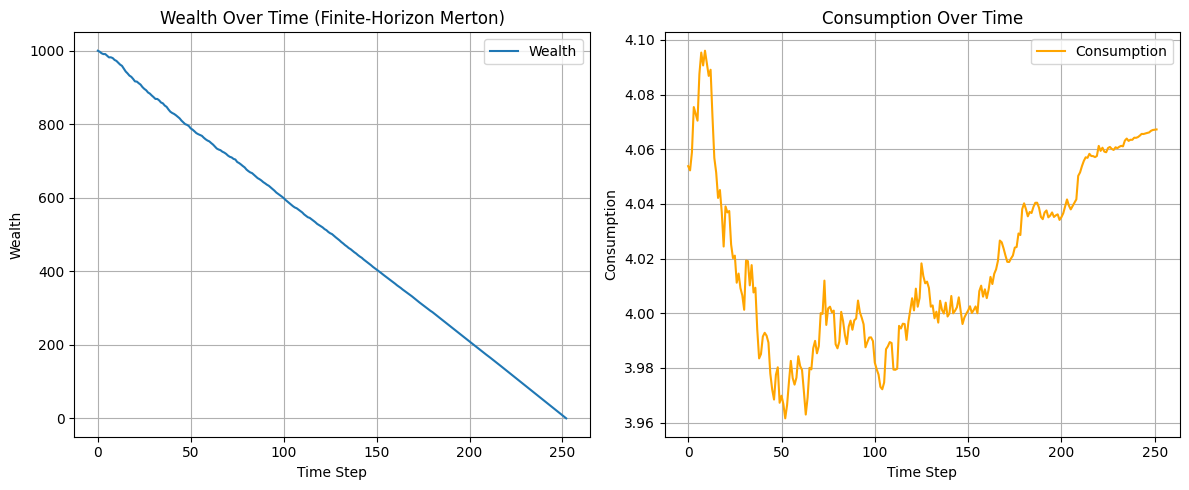


Final Wealth: -0.00
Terminal Utility: -13.2738


In [ ]:
def run_merton_finite_horizon():
    mu, sigma, r, T, dt, s0 = annu_mu_nifty, annu_sigma_nifty,0.065, 1.0, 1 / 252, nifty['Close'].iloc[-1].item()
    initial_wealth = 1000
    gamma = 1  # Log utility
    rho = 0.04

    market = Market(mu, sigma, r, T, dt, s0)
    strategy = MertonStrategy(mu, sigma, r, gamma)
    portfolio = MertonPortfolio(initial_wealth, strategy, market, rho)
    portfolio.run()
    portfolio.plot_results()

    print(f"\nFinal Wealth: {portfolio.final_wealth:.2f}")
    print(f"Terminal Utility: {portfolio.terminal_utility:.4f}")

if __name__ == "__main__":
    run_merton_finite_horizon()

q LEARNING


Training Q-learning agent...

Sample of Learned Q-Values:
((1000, 0), (np.float64(0.0), np.float64(0.0))): -5.8564
((np.float64(1000.0), 1), (np.float64(0.0), np.float64(0.0))): -1.3813
((np.float64(1000.0), 2), (np.float64(0.0), np.float64(0.0))): -4.8396
((np.float64(1000.0), 3), (np.float64(0.0), np.float64(0.0))): -4.8004
((np.float64(1000.0), 4), (np.float64(0.0), np.float64(0.0))): -1.3807
((np.float64(1000.0), 5), (np.float64(0.0), np.float64(0.0))): -2.6229
((np.float64(1000.0), 6), (np.float64(0.0), np.float64(0.0))): -2.6438
((np.float64(1000.0), 7), (np.float64(0.0), np.float64(0.0))): -1.3800
((np.float64(1000.0), 8), (np.float64(0.5), np.float64(0.15))): -0.1592
((np.float64(1000.0), 9), (np.float64(0.5), np.float64(0.2))): -0.2520


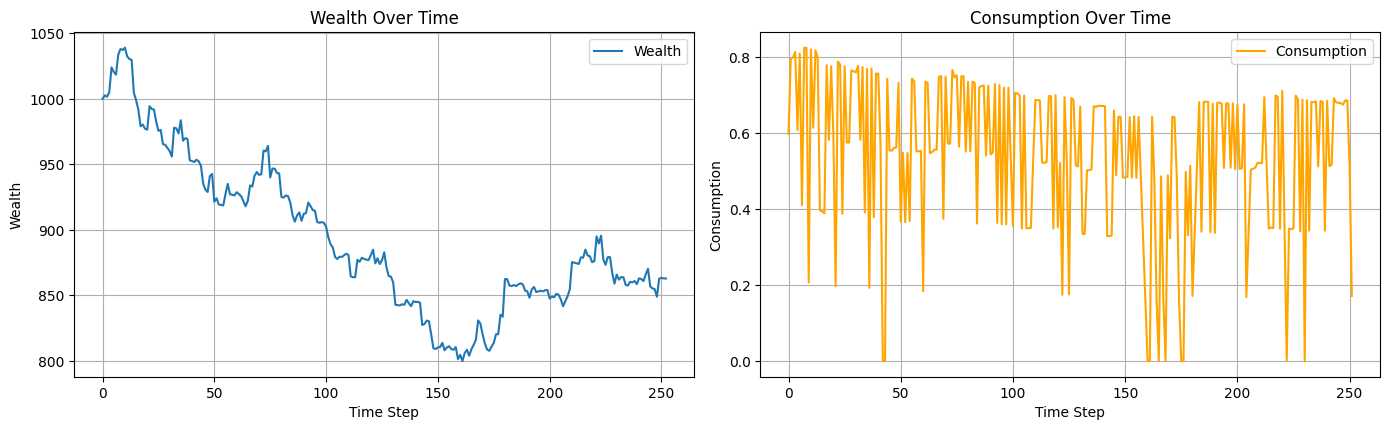


Final Wealth (Q-Learning Policy): 862.92


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#  Market Environment
class Market:
    def __init__(self, mu, sigma, r, T, dt, s0):
        self.mu = mu
        self.sigma = sigma
        self.r = r
        self.T = T
        self.dt = dt
        self.steps = int(T / dt)
        self.s0 = s0
        self.prices = self.simulate_prices()

    def simulate_prices(self):
        np.random.seed(42)
        prices = [self.s0]
        for _ in range(self.steps):
            s = prices[-1]
            dw = np.random.normal(0, np.sqrt(self.dt))
            s_new = s * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.dt + self.sigma * dw)
            prices.append(s_new)
        return prices

# Q-Learning Environment
class QLearningEnvironment:
    def __init__(self, market, initial_wealth, rho):
        self.market = market
        self.initial_wealth = initial_wealth
        self.rho = rho
        self.T = market.T
        self.dt = market.dt
        self.steps = market.steps
        self.reset()

    def reset(self):
        self.t = 0
        self.wealth = self.initial_wealth
        return self.get_state()

    def get_state(self):
        return (round(self.wealth, -1), self.t)

    def step(self, action):
        alloc, cons_frac = action
        price_now = self.market.prices[self.t]
        price_next = self.market.prices[self.t + 1]

        risky = alloc * self.wealth
        riskless = (1 - alloc) * self.wealth
        risky_return = (price_next - price_now) / price_now
        riskless_return = (1 + self.market.r) ** self.dt - 1

        new_wealth = risky * (1 + risky_return) + riskless * (1 + riskless_return)
        consumption = cons_frac * new_wealth * self.dt
        new_wealth -= consumption
        new_wealth = max(new_wealth, 1e-6)

        reward = np.log(consumption + 1e-6) * np.exp(-self.rho * self.t * self.dt)
        self.wealth = new_wealth
        self.t += 1

        done = (self.t >= self.steps)
        if done:
            reward += np.log(self.wealth + 1e-6) * np.exp(-self.rho * self.T)

        return self.get_state(), reward, done

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.actions[np.random.choice(len(self.actions))]
        q_values = [self.get_q(state, a) for a in self.actions]
        return self.actions[np.argmax(q_values)]

    def update(self, state, action, reward, next_state, done):
        max_q_next = max([self.get_q(next_state, a) for a in self.actions], default=0)
        target = reward if done else reward + self.gamma * max_q_next
        current_q = self.get_q(state, action)
        new_q = current_q + self.alpha * (target - current_q)
        self.q_table[(state, action)] = new_q

# Q-Learning Training Loop
def train_q_learning(env, agent, episodes=1000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state

# Policy Simulation
def simulate_q_policy(env, agent):
    state = env.reset()
    wealth_history = [env.wealth]
    consumption_history = []
    allocation_history = []
    consumption_rate_history = []

    while not env.t >= env.steps:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)

        alloc, cons_frac = action
        consumption = cons_frac * env.wealth * env.dt
        consumption_history.append(consumption)
        wealth_history.append(env.wealth)
        allocation_history.append(alloc)
        consumption_rate_history.append(cons_frac)

        state = next_state

    return wealth_history, consumption_history, allocation_history, consumption_rate_history

# Plotting
def plot_q_learning_results(wealth_history, consumption_history, allocation_history, consumption_rate_history):
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(wealth_history, label="Wealth")
    plt.xlabel("Time Step")
    plt.ylabel("Wealth")
    plt.title("Wealth Over Time")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(consumption_history, label="Consumption", color='orange')
    plt.xlabel("Time Step")
    plt.ylabel("Consumption")
    plt.title("Consumption Over Time")
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()

#  Main Run Function
def run_q_learning():
    mu, sigma, r, T, dt, s0 = 0.08, 0.2, 0.03, 1, 1 / 252, 100
    initial_wealth = 1000
    rho = 0.04
    market = Market(mu, sigma, r, T, dt, s0)

    # Define action space
    allocs = np.round(np.linspace(0, 1, 5), 2)
    consumptions = np.round(np.linspace(0, 0.2, 5), 3)
    actions = [(a, c) for a in allocs for c in consumptions]

    env = QLearningEnvironment(market, initial_wealth, rho)
    agent = QLearningAgent(actions)

    print("Training Q-learning agent...")
    train_q_learning(env, agent)

    # Print sample of learned Q-values
    print("\nSample of Learned Q-Values:")
    for i, key in enumerate(agent.q_table.keys()):
        if i < 10:
            print(f"{key}: {agent.q_table[key]:.4f}")

    # Simulate and plot
    wealth_hist, cons_hist, alloc_hist, cons_rate_hist = simulate_q_policy(env, agent)
    plot_q_learning_results(wealth_hist, cons_hist, alloc_hist, cons_rate_hist)

    print(f"\nFinal Wealth (Q-Learning Policy): {wealth_hist[-1]:.2f}")

# Run Everything
if __name__ == "__main__":
    run_q_learning()


Training Q-learning agent...

Sample of Learned Q-Values:
((1000, 0), (np.float64(0.0), np.float64(0.0))): -1.3816
((np.float64(1000.0), 1), (np.float64(0.0), np.float64(0.0))): -1.3813
((np.float64(1000.0), 2), (np.float64(0.0), np.float64(0.0))): -1.3811
((np.float64(1000.0), 3), (np.float64(0.0), np.float64(0.0))): -1.3809
((np.float64(1000.0), 4), (np.float64(0.0), np.float64(0.0))): -1.3807
((np.float64(1000.0), 5), (np.float64(0.0), np.float64(0.0))): -1.3805
((np.float64(1000.0), 6), (np.float64(0.0), np.float64(0.0))): -1.3802
((np.float64(1000.0), 7), (np.float64(0.0), np.float64(0.0))): -1.3800
((np.float64(1000.0), 8), (np.float64(0.9495), np.float64(0.3535))): 0.0334
((np.float64(990.0), 9), (np.float64(0.2121), np.float64(0.4141))): 18.5959


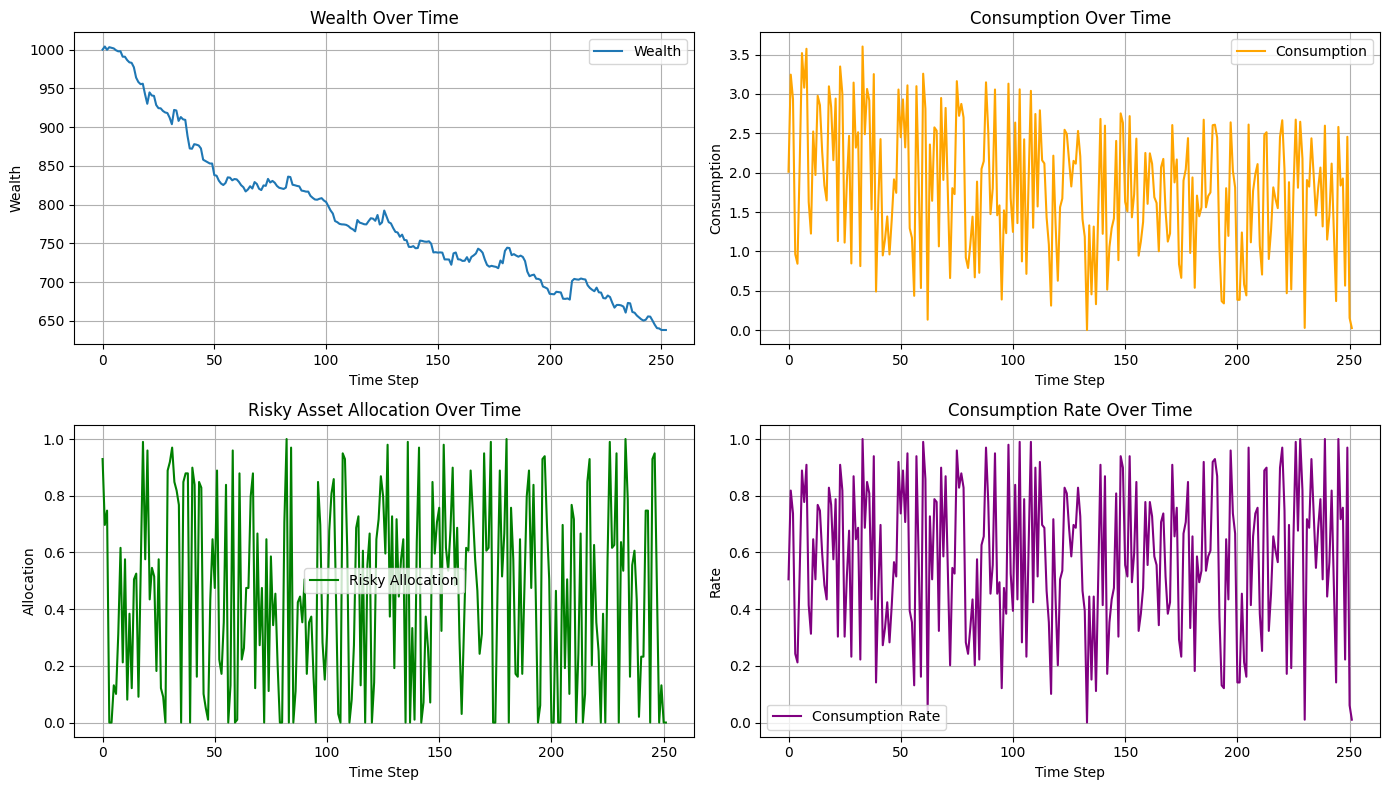


Final Wealth (Q-Learning Policy): 638.29


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Market Environment
class Market:
    def __init__(self, mu, sigma, r, T, dt, s0):
        self.mu = mu
        self.sigma = sigma
        self.r = r
        self.T = T
        self.dt = dt
        self.steps = int(T / dt)
        self.s0 = s0
        self.prices = self.simulate_prices()

    def simulate_prices(self):
        np.random.seed(42)
        prices = [self.s0]
        for _ in range(self.steps):
            s = prices[-1]
            dw = np.random.normal(0, np.sqrt(self.dt))
            s_new = s * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.dt + self.sigma * dw)
            prices.append(s_new)
        return prices

# Q-Learning Environment
class QLearningEnvironment:
    def __init__(self, market, initial_wealth, rho):
        self.market = market
        self.initial_wealth = initial_wealth
        self.rho = rho
        self.T = market.T
        self.dt = market.dt
        self.steps = market.steps
        self.reset()

    def reset(self):
        self.t = 0
        self.wealth = self.initial_wealth
        return self.get_state()

    def get_state(self):
        # Discretize wealth and time for tabular Q-learning
        return (round(self.wealth, -1), self.t)

    def step(self, action):
        alloc, cons_frac = action  # allocation to risky asset and consumption fraction
        price_now = self.market.prices[self.t]
        price_next = self.market.prices[self.t + 1]

        # Compute returns from risky and risk-free assets
        risky = alloc * self.wealth
        riskless = (1 - alloc) * self.wealth
        risky_return = (price_next - price_now) / price_now
        riskless_return = (1 + self.market.r) ** self.dt - 1

        # Update wealth before consumption
        new_wealth = risky * (1 + risky_return) + riskless * (1 + riskless_return)

        # Compute and subtract consumption
        consumption = cons_frac * new_wealth * self.dt
        # prevent over-consumption consumption=min(consumption, new_wealth)
        new_wealth -= consumption
        new_wealth = max(new_wealth, 1e-6)  # ensure positive wealth

        # Compute reward: discounted log utility from consumption
        time = self.t * self.dt
        reward = np.log(consumption + 1e-6) * np.exp(-self.rho * time)

        # Advance environment state
        self.wealth = new_wealth
        self.t += 1
        done = (self.t >= self.steps)

        # Add terminal utility reward
        if done:
            reward += np.log(self.wealth + 1e-6) * np.exp(-self.rho * self.T)

        return self.get_state(), reward, done

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = {}
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_q(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.actions[np.random.choice(len(self.actions))]
        q_values = [self.get_q(state, a) for a in self.actions]
        return self.actions[np.argmax(q_values)]

    def update(self, state, action, reward, next_state, done):
        max_q_next = max([self.get_q(next_state, a) for a in self.actions], default=0)
        target = reward if done else reward + self.gamma * max_q_next
        current_q = self.get_q(state, action)
        new_q = current_q + self.alpha * (target - current_q)
        self.q_table[(state, action)] = new_q

# Q-Learning Training Loop
def train_q_learning(env, agent, episodes=1000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state

#Policy Simulation
def simulate_q_policy(env, agent):
    state = env.reset()
    wealth_history = [env.wealth]
    consumption_history = []
    allocation_history = []
    consumption_rate_history = []

    while env.t < env.steps:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)

        alloc, cons_frac = action
        consumption = cons_frac * env.wealth * env.dt
        consumption_history.append(consumption)
        wealth_history.append(env.wealth)
        allocation_history.append(alloc)
        consumption_rate_history.append(cons_frac)

        state = next_state

    return wealth_history, consumption_history, allocation_history, consumption_rate_history

# Plotting
def plot_q_learning_results(wealth_history, consumption_history, allocation_history, consumption_rate_history):
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(wealth_history, label="Wealth")
    plt.xlabel("Time Step")
    plt.ylabel("Wealth")
    plt.title("Wealth Over Time")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(consumption_history, label="Consumption", color='orange')
    plt.xlabel("Time Step")
    plt.ylabel("Consumption")
    plt.title("Consumption Over Time")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(allocation_history, label="Risky Allocation", color='green')
    plt.xlabel("Time Step")
    plt.ylabel("Allocation")
    plt.title("Risky Asset Allocation Over Time")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(consumption_rate_history, label="Consumption Rate", color='purple')
    plt.xlabel("Time Step")
    plt.ylabel("Rate")
    plt.title("Consumption Rate Over Time")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main Run Function
def run_q_learning():
    mu, sigma, r, T, dt, s0 = 0.08, 0.2, 0.03, 1, 1 / 252, 100
    initial_wealth = 1000
    rho = 0.04
    market = Market(mu, sigma, r, T, dt, s0)

    # Define action space
    allocs = np.round(np.linspace(0, 1, 100), 4)
    consumptions = np.round(np.linspace(0, 1, 100), 4) # interpolated process
    actions = [(a, c) for a in allocs for c in consumptions]

    env = QLearningEnvironment(market, initial_wealth, rho)
    agent = QLearningAgent(actions)

    print("Training Q-learning agent...")
    train_q_learning(env, agent)

    # Print sample of learned Q-values
    print("\nSample of Learned Q-Values:")
    for i, key in enumerate(agent.q_table.keys()):
        if i < 10:
            print(f"{key}: {agent.q_table[key]:.4f}")

    # Simulate and plot
    wealth_hist, cons_hist, alloc_hist, cons_rate_hist = simulate_q_policy(env, agent)
    plot_q_learning_results(wealth_hist, cons_hist, alloc_hist, cons_rate_hist)

    print(f"\nFinal Wealth (Q-Learning Policy): {wealth_hist[-1]:.2f}")

#  Run Everything
if __name__ == "__main__":
    run_q_learning()
